# Image Classifier - MIDAS INTERNSHIP CHALLENGE

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Explanation - 1
The following code is used to import the our 3rd Party Deep Learning Libraries like *Pytorch* as well as checks, if the GPU is set or not.

<img src ="https://cdn-images-1.medium.com/max/2600/1*aqNgmfyBIStLrf9k7d9cng.jpeg"/>

In [2]:
from fastai.vision import *
import csv
from fastai.metrics import error_rate
from lr_finder import LRFinder
import pandas as pd
import time
from torch.utils.data.sampler import SubsetRandomSampler
import os
from torch.autograd import Variable
import matplotlib.image as mpimg
from PIL import Image
import torch
import copy
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim
import torch.optim as optim
import numpy as np
import torch
import pickle
import os
import torchvision
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Device is usage: {0}".format(device))

Device is usage: cuda:0


/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Explanation 2

### Intuition
The code block below defines few global variables that we would like to take care of, for example the batch size for our Deep Learning Pipeline as well as the paths of the training data/labels as well as the test_data

In [3]:
data_path = "./data"
train_images_path = "{0}/train_image.pkl".format(data_path)
test_images_path = "{0}/test_image.pkl".format(data_path)
train_labels_path = "{0}/train_label.pkl".format(data_path)
sanitized_labels_path = "{0}/train_labels_sanitized.pkl".format(data_path)
batch_size = 64
random_seed = 43
validation_split = 0.2
shuffle_dataset = True
torch.manual_seed(random_seed)

with open(test_images_path, "rb") as file:
    test_data = torch.ByteTensor(pickle.load(file)).view(-1, 28, 28) 

In [4]:
def path_exists(path):
    """
     Function to verfiy if, file path defined is correct
    """
    return os.path.exists(path)

valid_path = [path_exists(_) for _ in (train_images_path, test_images_path, train_labels_path)]
valid_path

[True, True, True]

In [5]:
def sanitize_labels(labels_path):
    """
        The labels given in the file are 0, 2, 3, 6
        Each label should be mapped to required class, as 0 -> 0, 2 -> 2, 3 -> 2, 6 -> 3
    """
    mapping = {0: 0, 2: 1, 3: 2, 6: 3}
    with open(labels_path, 'rb') as file:
        data = pickle.load(file)
    result = [mapping[i] for i in data]
    return result

result = sanitize_labels(train_labels_path)

with open(sanitized_labels_path, "wb") as file:
    pickle.dump(result, file)

path_exists(sanitized_labels_path)

True

## Deep Learning Pipeline - Data Pre-processing

<img src="https://cdn-images-1.medium.com/max/1200/1*ZX05x1xYgaVoa4Vn2kKS9g.png" />

### What's happening ?
In the code block we have defined a basic class which takes care of our pre-processing pipeline.

#### Why did we **inherit** the `Dataset`  class ?
We are using PyTorch as our DeepLearning framework, PyTorch provides a very simple API to build the Deep Learnign PipeLine, we can do make our own pipeline by inheriting the **Dataset** class, which has internal methods to take of the things we need to take care of pre-processing.

Here in our case I have divided the pipelin in the following parts.
- Load data from pickle dump.
- Build an API to *clean the data*, or arrange the data in a format that PyTorch understands, this has been done by the `__getitem__()` function.
    - This functions iteratively returns a single dataset and the following label for our Neural Net to work on. 
- We also incorporate transformations in the class, which helps us normalising our data.
    - **Normalising** input data is important, as this helps *Gradient Descent* to run faster, which means we can use a higher learning rate for our Neural Network, this helps us the reacht the minima faster, the contour of the cost functions are symmetrical when data is normalised.


In [6]:
class DataSetLoader(Dataset):
    '''Dataset Loader'''
    def __init__(self, train_path, labels_path, transform=None, train=True, target_transform=None):
        """
        Args:
            train_path (string): Path to the training data file
            labels_path (string): Path to the labels present for the training data
            transform (callable): Optional transform to apply to sample
        """
        self.test_lables = []
        self.train=train
        if self.train:
            data = self._load_from_pickle(train_path)
            self.train_data = torch.ByteTensor(data).view(-1, 28, 28) 
            self.train_labels = self._load_from_pickle(labels_path)
        else:
            data = self._load_from_pickle(train_path)
            self.test_data = torch.ByteTensor(data).view(-1, 28, 28) 
            self.test_lables = [i for i in range(len(data))]

            
        del data
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        """
         Returns the length of whole Dataset fed into the Neural Net.
        """
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)
    
    def __getitem__(self, index):
        """
         Returns a single training/test example after applying the required normalisation/transformations techniques.
         As well as the label.
         
         ret: (image, label)
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_lables[index]

        # return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
    
    def _load_from_pickle(self, file_path):
        """
         file_path: File path to load data, returns an ndarray
         
         ret: Loaded dump, in primitive data format.
        """
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        return data
    
    def get_labels(self):
        """
         Return an array of labels present in the data set.
        """
        if self.train:
            return np.unique(self.train_labels)
        return []
    
    def visualise_data_set(self):
        """
         Utility function to randomly display images from the dataset
        """
        fig = plt.figure(figsize=(8,8))
        columns = 4
        rows = 5
        if self.train:
            data_set = self.train_data
        else:
            data_set = self.test_data
        for i in range(1, columns * rows +1):
            img_xy = np.random.randint(len(data_set));
            img = data_set[img_xy][0][0,:,:]
            fig.add_subplot(rows, columns, i)
            plt.title(labels_map[data_set[img_xy][1]])
            plt.axis('off')
            plt.imshow(img)
        
        plt.show()            

In [7]:
# Creating a labels map for storing the labels


# Define the normalisation/tranformation techniques we need during pre-processing.
img_transforms = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

In [8]:
# Create training and test data sets.
train_dataset = DataSetLoader(train_images_path, sanitized_labels_path, train=True, transform=img_transforms)
test_dataset = DataSetLoader(test_images_path, "", train=False, transform=img_transforms)

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

## Looking at the data

The following code blocks gives us some insights about what kind of images our data set has.
By looking at the training set, we have 4 labels, *0, 2 ,3, 6*, these labels are numerically labelled in our training labelled data set.

Just for readibilty I have created a dictionary of mapping each numerical label to a physical label, like *Shirt*, *T-Shirt* etc.

```
labels = train_dataset.get_labels()
```
The code above gives us the unique labels present in our training data.
```
labels_map = {0 : 'T-Shirt', 1 : 'Pullover', 2 : 'Dress', 3 : 'Shirt'}
```
Initialises a dictionary to map each numerical label to a physical entity.

In [9]:
labels = train_dataset.get_labels()
labels_map = {0 : 'T-Shirt', 1 : 'Pullover', 2 : 'Dress', 3 : 'Shirt'}
reverse_mapping = {0: 0, 1: 2, 2: 3, 3: 6}
for label in labels:
    print("Label: {0}, value: {1}".format(label, labels_map[label]))
class_names = ['T-Shirt','Pullover', 'Dress', 'Shirt']

Label: 0, value: T-Shirt
Label: 1, value: Pullover
Label: 2, value: Dress
Label: 3, value: Shirt


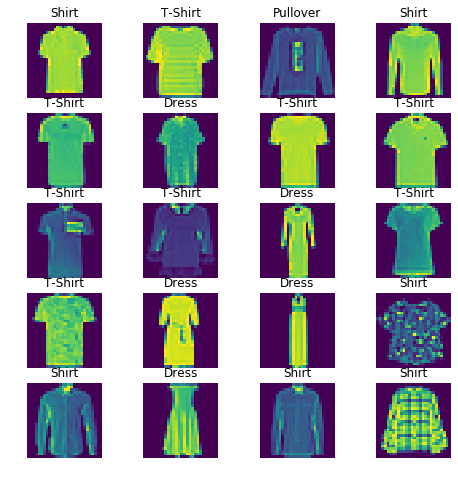

In [10]:
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img)
plt.show()


### Explanation of code block below

For our data pre-processing we have cleaned our data, applied required transformations, as well as wrote a simple API that allows us to do the steps gracefully.
What we need now is another API which can help us in iterating over our training/test datasets efficiently.

The following code does the same, **DataLoader** class provides us with an *Python* `iterator` object which allows for traverse over our dataset very efficiently, in specific batch size we want.

```
for i_batch, sample_batched in enumerate(trainloader):
    do_something(sample_batched)
```

Since trainloader is an iterator we can easily now iterate over our data set, you can also the see the code example above.

#### What's my intuition behind this ?

The most basic intuition in making an iterator here is we need to carry the basic Neural Net operations: 
  - Forward Propagation 
  - Backward Propagation

Since we want to carry out **Mini Batch Gradient Descent** for our Neural Network to learn the hyper-params, we are using this iterator to automatically create the required batches.

In [11]:
"""
    We built our data set using DataSetLoader class we defined above, now we need the the following operations
    1. Divide our dataset the into the batch sizes.
    2. Shuffle the dataset accordingly for randomness.
"""
trainloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=2)

validationloader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=2)

testloader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True, num_workers=2)

## Model Creation

### What is code block doing ?
The code block below defines the architecture of our Convolutional Neural Network. Our input is an image of dimensions (28 x 28), usually images have 3 channels, **RED, BLUE AND GREEN**, but in the current data set we have only 1 channel, due to this we initialise our Convolutional Layer accordingly.

In the first Convolutional block of our CNN we use only a single channel that is 1, becaue input image has only 1 channel.
```
class CNN(nn.Module):
    def __init__(self):
     .....
     nn.Conv2d(1, 16, kernel_size=4, padding=2)
     .....
```

Similarly.

```
class CNN(nn.Module):

    def __init__(self):
        .....
        nn.Conv2d(16, 32, kernel_size=6, padding=2),
        ....
```
In the second Convolutional Block, the number of input channels are 16 as the number of channels that will be received from CNN block 1 are 16.

The code block above specifies that our Convolutional Blocks have a padding of 2 and kernel size of 5.
We use BatchNormalisation to smoothen our loss landscape, and we use Dropout as a regularisation technique to keep overfitting in check.

### My Intuition

The basic intuition behind the CNN architecture is to involve techniques like Batch Normalization and Regularisation techniques like Dropout, on one hand, as well know Gradient Descent will converge to a minima for the training set, 
but if the number of epochs are high, then this can lead to overfitting. 

One another important factor to keep in-check is how we initialise weights, if weights are too small, gradients can vanish easily, if weights are too large, gradients can explode, to take care of the this issue, we initialise the weights with according to ideas presented in the paper ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf), if we initialise the weights of our Neural Netowk using the techniques presented in the paper, we can help reduce the chances of vanishing/exploding gradients.

```
    def weights_initialisation(m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
```

The code snippet above initialises the weights of our convolutional filters with a variance of `(2/n)`, where n is the size of input of the layer, as per the ideas ideas presented in the paper ["Understanding the difficulty of training deep feedforward neural networks"](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).


therefore:
   - Dropout helps in regularising our weights to reduce overfitting, I have kept the probability of regularisation as 0.5
   - Batch Normalization smoothens the loss landscape and thus allows to converge faster to minima, using Gradient Descent.
   - Xavier Initialisation, can help in reducing vanishing/exploding gradients.

In [12]:
def weights_initialisation(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)
        
class CNN(nn.Module):
    """
        CNN architecture:
        CONV -> BatchNorm -> Relu -> MaxPool -> CONV -> BatchNorm -> Relu -> Dropout -> MaxPool -> Linear -> Output
    """
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            # 16 is the number of channels
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),
            nn.MaxPool2d(2))
        # Number of classes is 4
        self.fc = nn.Linear(3 * 3 * 32, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

## Finding Hyper-parmeters

Finding hyper-paramters are very important for buidling a good classifier, one of the most important one is *learning rate*
There can two approaches we can take here to find the appropriate learning rate.
   - We can do a grid search of learning rate vs epochs to find the combination for the model with the best accuracy on our validation set.
     - This is might take great lenghts of time to find the right learning rate.
   - Or we can do use the ideas from the paper: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186.pdf), to find the a good learning rate range for our model.
   
The code below depicts what can be possible learning rates for our CNN, given our training and validation set.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


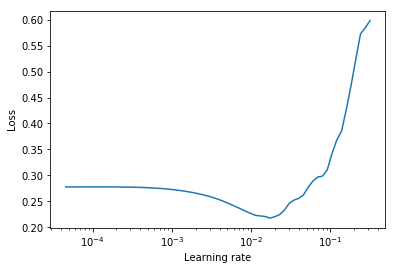

In [13]:
# Find learning rate using Exponential decay
net = CNN().cuda().apply(weights_initialisation)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
lr_finder = LRFinder(net, optimizer, nn.CrossEntropyLoss().cuda(), device="cuda")
lr_finder.range_test(trainloader, val_loader=validationloader, end_lr=10)
lr_finder.plot()
history = lr_finder.history
lr_finder.reset()

From the graphs above, we can consider the range of rates where the graph steeps downwards continously, that range can be taken as an approximate learning rate for our network, why? because the loss is calculated on our validation set `validationloader`, which is being passed in our code above, as the loss is continously decreasing, it makes sense to use that range as our range of learning rate.

Therefore, we can use an approximate learning rate of from 0.001 to 0.01, here.

## Model Training

The code below is an abstraction over how we will be training our model on our training data.

```
class ModelRunner:

    def __init__(self, learning_rate, epochs):
        .....
    
    def run_model(self):
        .....
       
     def plot_losses(self):
         .....
```
The code snippets above gives us the simple API to train our selected model on specific hyper-paramters we want.
We have already seen the range of learning rate we need to keep so that our model can converge as well as reduce over-fitting.

We now need to find the right range of epochs for which we need to train our model.
We will use a technique called *Grid Search* to find the right set of paramters.

Once our models are trained on those hyper-paramters, we will use our validation-set, `vaidationloader` to find the model which has the better accuracy.

I have wrriten to this code snippet, so that I can easily do a grid search, save the data from the grid-search and then use our *validation set* to find which set of parameters are the best.

In [14]:
class ModelRunner:
    """
        Class to abstract how we train our model on training and validation data sets.
    """
    def __init__(self, learning_rate, epochs):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.training_losses = []
    
    def initialise_model(self):
        self.model = CNN().cuda()
        self.criterion = nn.CrossEntropyLoss().cuda()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
    
    def run_model(self):
        self.initialise_model()
        print("-------Running Model, with rate: {0} and epochs: {1} -------".format(self.learning_rate, self.epochs))
        for epoch in range(self.epochs):
            for i, (images, labels) in enumerate(trainloader):
                images = Variable(images.to(device).float())
                labels = Variable(labels.cuda())
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                self.training_losses.append(loss.data.item())
        
                if (i+1) % 100 == 0:
                    print('Epoch : %d/%d, Iter : %d/%d, Training Loss: %.4f' 
                       %(epoch+1, self.epochs, i+1, len(train_dataset)//batch_size, loss.data.item()))
        
        self.plot_losses()
        print("\n \n")
        return self.model
    
    def plot_losses(self):
        plt.xlabel('Epoch #')
        plt.ylabel('Loss')
        plt.plot(self.training_losses[::100])
        plt.show()

-------Running Model, with rate: 0.001 and epochs: 40 -------
Epoch : 1/40, Iter : 100/125, Training Loss: 0.7931
Epoch : 2/40, Iter : 100/125, Training Loss: 0.5093
Epoch : 3/40, Iter : 100/125, Training Loss: 0.4396
Epoch : 4/40, Iter : 100/125, Training Loss: 0.3960
Epoch : 5/40, Iter : 100/125, Training Loss: 0.2918
Epoch : 6/40, Iter : 100/125, Training Loss: 0.4212
Epoch : 7/40, Iter : 100/125, Training Loss: 0.3809
Epoch : 8/40, Iter : 100/125, Training Loss: 0.3754
Epoch : 9/40, Iter : 100/125, Training Loss: 0.3699
Epoch : 10/40, Iter : 100/125, Training Loss: 0.3092
Epoch : 11/40, Iter : 100/125, Training Loss: 0.3309
Epoch : 12/40, Iter : 100/125, Training Loss: 0.3697
Epoch : 13/40, Iter : 100/125, Training Loss: 0.5675
Epoch : 14/40, Iter : 100/125, Training Loss: 0.1875
Epoch : 15/40, Iter : 100/125, Training Loss: 0.4508
Epoch : 16/40, Iter : 100/125, Training Loss: 0.2406
Epoch : 17/40, Iter : 100/125, Training Loss: 0.2950
Epoch : 18/40, Iter : 100/125, Training Loss: 

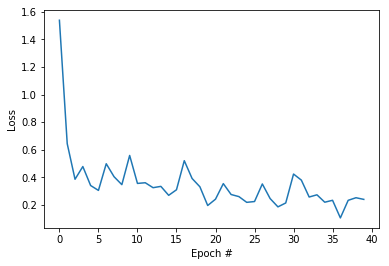


 

-------Running Model, with rate: 0.001 and epochs: 50 -------
Epoch : 1/50, Iter : 100/125, Training Loss: 0.7832
Epoch : 2/50, Iter : 100/125, Training Loss: 0.4840
Epoch : 3/50, Iter : 100/125, Training Loss: 0.4874
Epoch : 4/50, Iter : 100/125, Training Loss: 0.5263
Epoch : 5/50, Iter : 100/125, Training Loss: 0.4423
Epoch : 6/50, Iter : 100/125, Training Loss: 0.4611
Epoch : 7/50, Iter : 100/125, Training Loss: 0.4254
Epoch : 8/50, Iter : 100/125, Training Loss: 0.4460
Epoch : 9/50, Iter : 100/125, Training Loss: 0.3808
Epoch : 10/50, Iter : 100/125, Training Loss: 0.3792
Epoch : 11/50, Iter : 100/125, Training Loss: 0.2935
Epoch : 12/50, Iter : 100/125, Training Loss: 0.2550
Epoch : 13/50, Iter : 100/125, Training Loss: 0.3902
Epoch : 14/50, Iter : 100/125, Training Loss: 0.2954
Epoch : 15/50, Iter : 100/125, Training Loss: 0.4474
Epoch : 16/50, Iter : 100/125, Training Loss: 0.4019
Epoch : 17/50, Iter : 100/125, Training Loss: 0.2492
Epoch : 18/50, Iter : 100/125, Training Lo

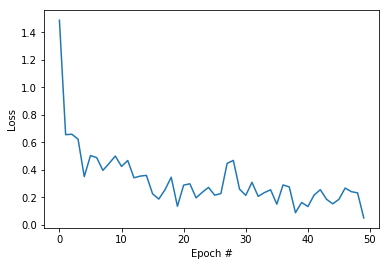


 

-------Running Model, with rate: 0.001 and epochs: 60 -------
Epoch : 1/60, Iter : 100/125, Training Loss: 0.5886
Epoch : 2/60, Iter : 100/125, Training Loss: 0.6776
Epoch : 3/60, Iter : 100/125, Training Loss: 0.6720
Epoch : 4/60, Iter : 100/125, Training Loss: 0.4606
Epoch : 5/60, Iter : 100/125, Training Loss: 0.4589
Epoch : 6/60, Iter : 100/125, Training Loss: 0.5467
Epoch : 7/60, Iter : 100/125, Training Loss: 0.6740
Epoch : 8/60, Iter : 100/125, Training Loss: 0.4133
Epoch : 9/60, Iter : 100/125, Training Loss: 0.4187
Epoch : 10/60, Iter : 100/125, Training Loss: 0.3905
Epoch : 11/60, Iter : 100/125, Training Loss: 0.4094
Epoch : 12/60, Iter : 100/125, Training Loss: 0.4415
Epoch : 13/60, Iter : 100/125, Training Loss: 0.5472
Epoch : 14/60, Iter : 100/125, Training Loss: 0.3852
Epoch : 15/60, Iter : 100/125, Training Loss: 0.5039
Epoch : 16/60, Iter : 100/125, Training Loss: 0.3214
Epoch : 17/60, Iter : 100/125, Training Loss: 0.3017
Epoch : 18/60, Iter : 100/125, Training Lo

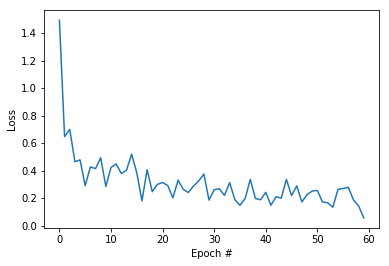


 

-------Running Model, with rate: 0.003 and epochs: 40 -------
Epoch : 1/40, Iter : 100/125, Training Loss: 0.5485
Epoch : 2/40, Iter : 100/125, Training Loss: 0.5161
Epoch : 3/40, Iter : 100/125, Training Loss: 0.4662
Epoch : 4/40, Iter : 100/125, Training Loss: 0.3571
Epoch : 5/40, Iter : 100/125, Training Loss: 0.3917
Epoch : 6/40, Iter : 100/125, Training Loss: 0.3835
Epoch : 7/40, Iter : 100/125, Training Loss: 0.3306
Epoch : 8/40, Iter : 100/125, Training Loss: 0.3908
Epoch : 9/40, Iter : 100/125, Training Loss: 0.3800
Epoch : 10/40, Iter : 100/125, Training Loss: 0.3743
Epoch : 11/40, Iter : 100/125, Training Loss: 0.4751
Epoch : 12/40, Iter : 100/125, Training Loss: 0.2010
Epoch : 13/40, Iter : 100/125, Training Loss: 0.4354
Epoch : 14/40, Iter : 100/125, Training Loss: 0.1513
Epoch : 15/40, Iter : 100/125, Training Loss: 0.3143
Epoch : 16/40, Iter : 100/125, Training Loss: 0.3740
Epoch : 17/40, Iter : 100/125, Training Loss: 0.2974
Epoch : 18/40, Iter : 100/125, Training Lo

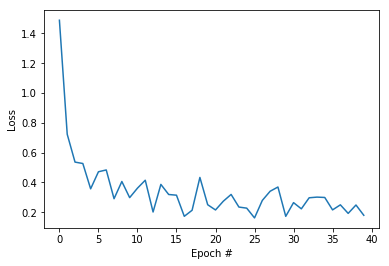


 

-------Running Model, with rate: 0.003 and epochs: 50 -------
Epoch : 1/50, Iter : 100/125, Training Loss: 0.6243
Epoch : 2/50, Iter : 100/125, Training Loss: 0.5787
Epoch : 3/50, Iter : 100/125, Training Loss: 0.5548
Epoch : 4/50, Iter : 100/125, Training Loss: 0.4915
Epoch : 5/50, Iter : 100/125, Training Loss: 0.4999
Epoch : 6/50, Iter : 100/125, Training Loss: 0.5268
Epoch : 7/50, Iter : 100/125, Training Loss: 0.2866
Epoch : 8/50, Iter : 100/125, Training Loss: 0.4195
Epoch : 9/50, Iter : 100/125, Training Loss: 0.5242
Epoch : 10/50, Iter : 100/125, Training Loss: 0.4259
Epoch : 11/50, Iter : 100/125, Training Loss: 0.3959
Epoch : 12/50, Iter : 100/125, Training Loss: 0.4221
Epoch : 13/50, Iter : 100/125, Training Loss: 0.2728
Epoch : 14/50, Iter : 100/125, Training Loss: 0.3070
Epoch : 15/50, Iter : 100/125, Training Loss: 0.4470
Epoch : 16/50, Iter : 100/125, Training Loss: 0.2782
Epoch : 17/50, Iter : 100/125, Training Loss: 0.2686
Epoch : 18/50, Iter : 100/125, Training Lo

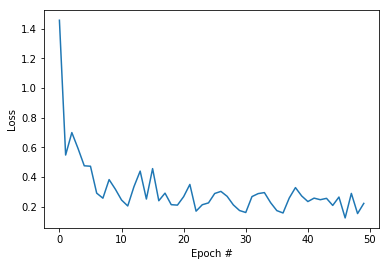


 

-------Running Model, with rate: 0.003 and epochs: 60 -------
Epoch : 1/60, Iter : 100/125, Training Loss: 0.6411
Epoch : 2/60, Iter : 100/125, Training Loss: 0.5264
Epoch : 3/60, Iter : 100/125, Training Loss: 0.5353
Epoch : 4/60, Iter : 100/125, Training Loss: 0.4153
Epoch : 5/60, Iter : 100/125, Training Loss: 0.3918
Epoch : 6/60, Iter : 100/125, Training Loss: 0.3489
Epoch : 7/60, Iter : 100/125, Training Loss: 0.4504
Epoch : 8/60, Iter : 100/125, Training Loss: 0.3457
Epoch : 9/60, Iter : 100/125, Training Loss: 0.4944
Epoch : 10/60, Iter : 100/125, Training Loss: 0.2767
Epoch : 11/60, Iter : 100/125, Training Loss: 0.3471
Epoch : 12/60, Iter : 100/125, Training Loss: 0.3898
Epoch : 13/60, Iter : 100/125, Training Loss: 0.2478
Epoch : 14/60, Iter : 100/125, Training Loss: 0.3687
Epoch : 15/60, Iter : 100/125, Training Loss: 0.5237
Epoch : 16/60, Iter : 100/125, Training Loss: 0.4067
Epoch : 17/60, Iter : 100/125, Training Loss: 0.2036
Epoch : 18/60, Iter : 100/125, Training Lo

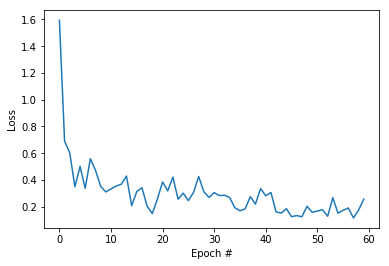


 

-------Running Model, with rate: 0.005 and epochs: 40 -------
Epoch : 1/40, Iter : 100/125, Training Loss: 0.8688
Epoch : 2/40, Iter : 100/125, Training Loss: 0.5341
Epoch : 3/40, Iter : 100/125, Training Loss: 0.4724
Epoch : 4/40, Iter : 100/125, Training Loss: 0.5952
Epoch : 5/40, Iter : 100/125, Training Loss: 0.3707
Epoch : 6/40, Iter : 100/125, Training Loss: 0.3415
Epoch : 7/40, Iter : 100/125, Training Loss: 0.4292
Epoch : 8/40, Iter : 100/125, Training Loss: 0.5621
Epoch : 9/40, Iter : 100/125, Training Loss: 0.3301
Epoch : 10/40, Iter : 100/125, Training Loss: 0.5069
Epoch : 11/40, Iter : 100/125, Training Loss: 0.4032
Epoch : 12/40, Iter : 100/125, Training Loss: 0.2716
Epoch : 13/40, Iter : 100/125, Training Loss: 0.2566
Epoch : 14/40, Iter : 100/125, Training Loss: 0.3307
Epoch : 15/40, Iter : 100/125, Training Loss: 0.2691
Epoch : 16/40, Iter : 100/125, Training Loss: 0.4114
Epoch : 17/40, Iter : 100/125, Training Loss: 0.3944
Epoch : 18/40, Iter : 100/125, Training Lo

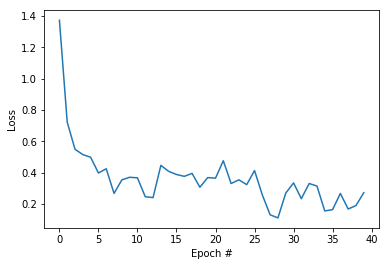


 

-------Running Model, with rate: 0.005 and epochs: 50 -------
Epoch : 1/50, Iter : 100/125, Training Loss: 0.6515
Epoch : 2/50, Iter : 100/125, Training Loss: 0.4792
Epoch : 3/50, Iter : 100/125, Training Loss: 0.4183
Epoch : 4/50, Iter : 100/125, Training Loss: 0.5471
Epoch : 5/50, Iter : 100/125, Training Loss: 0.4662
Epoch : 6/50, Iter : 100/125, Training Loss: 0.3470
Epoch : 7/50, Iter : 100/125, Training Loss: 0.4931
Epoch : 8/50, Iter : 100/125, Training Loss: 0.3570
Epoch : 9/50, Iter : 100/125, Training Loss: 0.5081
Epoch : 10/50, Iter : 100/125, Training Loss: 0.5246
Epoch : 11/50, Iter : 100/125, Training Loss: 0.2868
Epoch : 12/50, Iter : 100/125, Training Loss: 0.5116
Epoch : 13/50, Iter : 100/125, Training Loss: 0.2946
Epoch : 14/50, Iter : 100/125, Training Loss: 0.3308
Epoch : 15/50, Iter : 100/125, Training Loss: 0.3230
Epoch : 16/50, Iter : 100/125, Training Loss: 0.4973
Epoch : 17/50, Iter : 100/125, Training Loss: 0.1826
Epoch : 18/50, Iter : 100/125, Training Lo

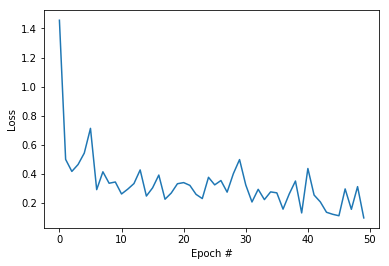


 

-------Running Model, with rate: 0.005 and epochs: 60 -------
Epoch : 1/60, Iter : 100/125, Training Loss: 0.5049
Epoch : 2/60, Iter : 100/125, Training Loss: 0.5220
Epoch : 3/60, Iter : 100/125, Training Loss: 0.3225
Epoch : 4/60, Iter : 100/125, Training Loss: 0.4326
Epoch : 5/60, Iter : 100/125, Training Loss: 0.4054
Epoch : 6/60, Iter : 100/125, Training Loss: 0.6647
Epoch : 7/60, Iter : 100/125, Training Loss: 0.5230
Epoch : 8/60, Iter : 100/125, Training Loss: 0.3763
Epoch : 9/60, Iter : 100/125, Training Loss: 0.4154
Epoch : 10/60, Iter : 100/125, Training Loss: 0.3953
Epoch : 11/60, Iter : 100/125, Training Loss: 0.3275
Epoch : 12/60, Iter : 100/125, Training Loss: 0.3388
Epoch : 13/60, Iter : 100/125, Training Loss: 0.4701
Epoch : 14/60, Iter : 100/125, Training Loss: 0.3312
Epoch : 15/60, Iter : 100/125, Training Loss: 0.2166
Epoch : 16/60, Iter : 100/125, Training Loss: 0.2852
Epoch : 17/60, Iter : 100/125, Training Loss: 0.3992
Epoch : 18/60, Iter : 100/125, Training Lo

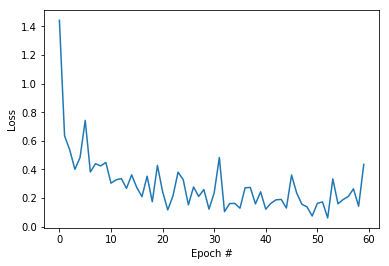

In [15]:
"""
    Doing a grid search over possible learning rates as well as epochs.
"""
models = []
learning_rates = [1e-3, 3e-3, 5e-3]
epochs = [40, 50, 60]
for rate in learning_rates:
    for epoch in epochs:
        runner = ModelRunner(rate, epoch)
        models.append({"model": runner.run_model(), "rate":rate, "epoch": epoch})

## Model Evaluation
Since now we have found our set of models over our grid-search, we need to evaluate which model is better for use.
Now since we have trained on our training set, we cannot validate our models on that set.

What we need is our validation-set, `validationloader`, we will test the accuracy of each model on our validation-set and find which one of them, is the most accurate.

I have written 2 functions for this.

```
def evaluate_model(model):
    ....
```
and

```
def find_best_model(models):
    ....
```
`evaluate_model(model)`, shows the accuracy of a single model on our validation set.

`find_best_model(models)`, takes a collection of models as input and returns the best model, with the correct combination of epochs and learning rate.

In [16]:
np.random.seed(random_seed)

def evaluate_model(model_obj):
    model_obj["model"].eval()
    correct = 0
    total = 0
    print("\n --- Epoch and learning rate are: {0} and {1} ----".format(model_obj["epoch"], model_obj["rate"]))
    for images, labels in validationloader:
        images, labels = images.to(device), labels.to(device)
        images = Variable(images.float())
        outputs = model_obj["model"](images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        print('Validation Accuracy of the model on validation images: %.4f %%' % (100 * correct / total))
        return (100 * correct / total)


def find_best_model(models):
    best_model = None
    best_metric = 0.0
    for model in models:
        metric = evaluate_model(model)
        if metric > best_metric:
            best_model = model
            best_metric = metric
    return best_model

In [17]:
best_model = find_best_model(models)
epoch, rate = best_model["epoch"], best_model["rate"]
print("\n\nBest combination of Number of epochs and learning rate found are: {0}, {1}".format(epoch, rate))

torch.save(best_model["model"].state_dict(), "model_weights.pt")


 --- Epoch and learning rate are: 40 and 0.001 ----
Validation Accuracy of the model on validation images: 95.0000 %

 --- Epoch and learning rate are: 50 and 0.001 ----
Validation Accuracy of the model on validation images: 89.0000 %

 --- Epoch and learning rate are: 60 and 0.001 ----
Validation Accuracy of the model on validation images: 89.0000 %

 --- Epoch and learning rate are: 40 and 0.003 ----
Validation Accuracy of the model on validation images: 82.0000 %

 --- Epoch and learning rate are: 50 and 0.003 ----
Validation Accuracy of the model on validation images: 92.0000 %

 --- Epoch and learning rate are: 60 and 0.003 ----
Validation Accuracy of the model on validation images: 90.0000 %

 --- Epoch and learning rate are: 40 and 0.005 ----
Validation Accuracy of the model on validation images: 87.0000 %

 --- Epoch and learning rate are: 50 and 0.005 ----
Validation Accuracy of the model on validation images: 84.0000 %

 --- Epoch and learning rate are: 60 and 0.005 ----
Val

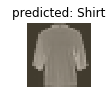

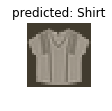

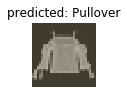

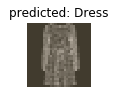

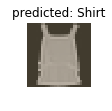

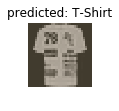

In [18]:
"""
    Helper functions to help us visualize our predictions
"""
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(validationloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(best_model["model"])

## Inference
The following code below is used to give more insights on how good our model is.

In [19]:
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
label_decoder = dict(zip(range(4), class_names))

print("|Item|Accuracy (%)|")
print("|-+-|")
with torch.no_grad():
    for images, labels in validationloader:
        images, labels = images.to(device), labels.to(device)
        images = Variable(images.float())
        outputs = best_model["model"](images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label.item()] += c[i].item()
            class_total[label.item()] += 1


for i in range(4):
    print('|{}|{:.1f}'.format(
        label_decoder[i], 100 * class_correct[i] / class_total[i]))

|Item|Accuracy (%)|
|-+-|
|T-Shirt|87.6
|Pullover|89.5
|Dress|96.0
|Shirt|78.3


Our model has good performance over T-Shirt, Pullover and Dress, but has fails to classify Shirts to a greater accuracy, this can be a result of class imbalance in our training set, we can solve this by sampling our training set in such a way that each class as particular number of examples, so that our classifier can understand the differences more.

## Testing and saving lables of our test set

The following code below loads our model, from the best state of model we saved previously and saves the predicted class in a csv file.

In [22]:
model = CNN()
model.load_state_dict(torch.load("model_weights.pt"))
model.eval()
count = 0
predictions = open('AKSHAY_SHARMA.csv', 'w')

with predictions:
    fnames = ['index', 'image_class']
    writer = csv.DictWriter(predictions, fieldnames=fnames)
    writer.writeheader()
    for i, (images, labels) in enumerate(testloader):
        images = Variable(images.float())
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        for index, value in enumerate(predicted):
            writer.writerow({'index':count, 'image_class': reverse_mapping[value.item()]})
            count += 1

# Conclusion
We have successfully created an image classifier, that can classify give image data into 4 classes.

To recap:
   - We pre-prprocessed the data, including normalisation of images and as well making training, validation and test set.
   - We defined a CNN architecture, used Xavier Initialisation, Batch Normalization and Dropout regularisation as part of our architecture.
   - We did our hyper-parameter search, to find the correct learning rate as well as the number of epochs.
   - Used grid-search, and then found the better model, by using our validation set.
   - We saw how our classifier is working on different classes, from the data used from our validation set.
   - In the end, we dumped the our predictions of our test set in a csv file.
 
**By Akshay Sharma**, <akshay.sharma09695@gmail.com>